### Importação das bibliotecas necessárias e carregamento da base de dados

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn2pmml import PMMLPipeline, sklearn2pmml

In [2]:
df = pd.read_csv("./database.csv")

### Modificação da base para facilitar a compreensão dos dados

Renomeando as colunas do dataset

In [5]:
df = df.rename(columns={
    'age':'idade',
    'sex':'sexo',
    'cp':'tipoDorToracica',
    'trestbps': 'pressaoSanguineaRepouso',
    'chol': 'colesterolSerico',
    'fbs': 'glicemiaJejum',
    'restecg': 'resultadosEletrocardiogramaRepouso',
    'thalach': 'frequenciaCardiacaMaxima',
    'exang': 'anginaInduzida',
    'oldpeak': 'depressaoSTInduzida',
    'slope': 'inclinacaoPicoST',
    'ca': 'numeroVasosPrincipais',
    'thal': 'avaliacaoTesteEsforco',
    'target': 'resultado'
})

Substituindo os valores das variáveis categóricas da base, que estão codificados, pelos seus valores nominais

In [6]:
df['sexo'] = df['sexo'].replace({0: 'Feminino', 1: 'Masculino'})
df['glicemiaJejum'] = df['glicemiaJejum'].replace({0: 'Menor que 120 mg/dl', 1: 'Maior que 120 mg/dl'})
df['anginaInduzida'] = df['anginaInduzida'].replace({0: 'Não', 1: 'Sim'})
df['avaliacaoTesteEsforco'] = df['avaliacaoTesteEsforco'].replace({1: 'Normal', 2: 'Problema irreversível', \
                                                                   3: 'Problema reversível'})
df['resultado'] = df['resultado'].replace({0: 'Doença cardíaca não detectada', 1: 'Doença cardíaca detectada'})

### Análise exploratória e limpeza dos dados

In [7]:
df.shape

(1025, 14)

A base conta com 1025 registros e 14 variáveis

In [8]:
df.head()

,idade,sexo,tipoDorToracica,pressaoSanguineaRepouso,colesterolSerico,glicemiaJejum,resultadosEletrocardiogramaRepouso,frequenciaCardiacaMaxima,anginaInduzida,depressaoSTInduzida,inclinacaoPicoST,numeroVasosPrincipais,avaliacaoTesteEsforco,resultado
0,52,Masculino,0,125,212,Menor que 120 mg/dl,1,168,Não,1.0,2,2,Problema reversível,Doença cardíaca não detectada
1,53,Masculino,0,140,203,Maior que 120 mg/dl,0,155,Sim,3.1,0,0,Problema reversível,Doença cardíaca não detectada
2,70,Masculino,0,145,174,Menor que 120 mg/dl,1,125,Sim,2.6,0,0,Problema reversível,Doença cardíaca não detectada
3,61,Masculino,0,148,203,Menor que 120 mg/dl,1,161,Não,0.0,2,1,Problema reversível,Doença cardíaca não detectada
4,62,Feminino,0,138,294,Maior que 120 mg/dl,1,106,Não,1.9,1,3,Problema irreversível,Doença cardíaca não detectada


In [9]:
df.tail()

,idade,sexo,tipoDorToracica,pressaoSanguineaRepouso,colesterolSerico,glicemiaJejum,resultadosEletrocardiogramaRepouso,frequenciaCardiacaMaxima,anginaInduzida,depressaoSTInduzida,inclinacaoPicoST,numeroVasosPrincipais,avaliacaoTesteEsforco,resultado
1020,59,Masculino,1,140,221,Menor que 120 mg/dl,1,164,Sim,0.0,2,0,Problema irreversível,Doença cardíaca detectada
1021,60,Masculino,0,125,258,Menor que 120 mg/dl,0,141,Sim,2.8,1,1,Problema reversível,Doença cardíaca não detectada
1022,47,Masculino,0,110,275,Menor que 120 mg/dl,0,118,Sim,1.0,1,1,Problema irreversível,Doença cardíaca não detectada
1023,50,Feminino,0,110,254,Menor que 120 mg/dl,0,159,Não,0.0,2,0,Problema irreversível,Doença cardíaca detectada
1024,54,Masculino,0,120,188,Menor que 120 mg/dl,1,113,Não,1.4,1,1,Problema reversível,Doença cardíaca não detectada


Por meio da análise visual dos primeiros e dos últimos registros da base, ainda não foi possível detectar inconsistências

In [10]:
linhas_duplicadas = df[df.duplicated()]
print(f'Total de linhas duplicadas: {linhas_duplicadas.shape[0]}')

Total de linhas duplicadas: 723


Uma grande quantidade de registros da base está duplicada. Como a natureza dos dados armazenados não prevê uma incidência tão alta de repetições, uma medida adequada é eliminar esses dados, embora o tamanho da base seja fortemente reduzido

In [11]:
df = df.drop_duplicates()
print(f'Registros restantes na base: {df.shape[0]}')

Registros restantes na base: 302


In [12]:
colunas_discretas = ['sexo', 'tipoDorToracica', 'glicemiaJejum', \
                     'resultadosEletrocardiogramaRepouso', 'anginaInduzida', \
                     'inclinacaoPicoST', 'numeroVasosPrincipais', \
                     'avaliacaoTesteEsforco', 'resultado']

In [13]:
colunas_continuas = ['idade', 'pressaoSanguineaRepouso', 'colesterolSerico', \
                     'frequenciaCardiacaMaxima', 'depressaoSTInduzida']

In [14]:
for coluna in colunas_discretas:
    valores_unicos = df[coluna].unique()
    print(f"Valores únicos em '{coluna}': {valores_unicos}")

Valores únicos em 'sexo': ['Masculino' 'Feminino']
Valores únicos em 'tipoDorToracica': [0 1 2 3]
Valores únicos em 'glicemiaJejum': ['Menor que 120 mg/dl' 'Maior que 120 mg/dl']
Valores únicos em 'resultadosEletrocardiogramaRepouso': [1 0 2]
Valores únicos em 'anginaInduzida': ['Não' 'Sim']
Valores únicos em 'inclinacaoPicoST': [2 0 1]
Valores únicos em 'numeroVasosPrincipais': [2 0 1 3 4]
Valores únicos em 'avaliacaoTesteEsforco': ['Problema reversível' 'Problema irreversível' 'Normal' 0]
Valores únicos em 'resultado': ['Doença cardíaca não detectada' 'Doença cardíaca detectada']


É possível detectar que existe uma classe '0' no atributo 'avaliacaoTesteEsforco'. Abaixo, é feita uma análise mais detalhada da situação

In [15]:
df['avaliacaoTesteEsforco'].value_counts()

avaliacaoTesteEsforco
Problema irreversível    165
Problema reversível      117
Normal                    18
0                          2
Name: count, dtype: int64

In [16]:
df.query('avaliacaoTesteEsforco == 0')

,idade,sexo,tipoDorToracica,pressaoSanguineaRepouso,colesterolSerico,glicemiaJejum,resultadosEletrocardiogramaRepouso,frequenciaCardiacaMaxima,anginaInduzida,depressaoSTInduzida,inclinacaoPicoST,numeroVasosPrincipais,avaliacaoTesteEsforco,resultado
14,52,Masculino,0,128,204,Maior que 120 mg/dl,1,156,Sim,1.0,1,0,0,Doença cardíaca não detectada
319,53,Feminino,2,128,216,Menor que 120 mg/dl,0,115,Não,0.0,2,0,0,Doença cardíaca detectada


Dada a pequena quantidade de registros com essa inconsistência e a impossibilidade de determinarmos um valor preciso para o atributo 'avaliacaoTesteEsforco', os dois registros inconsistentes serão apagados

In [17]:
df = df[df['avaliacaoTesteEsforco'] != 0]

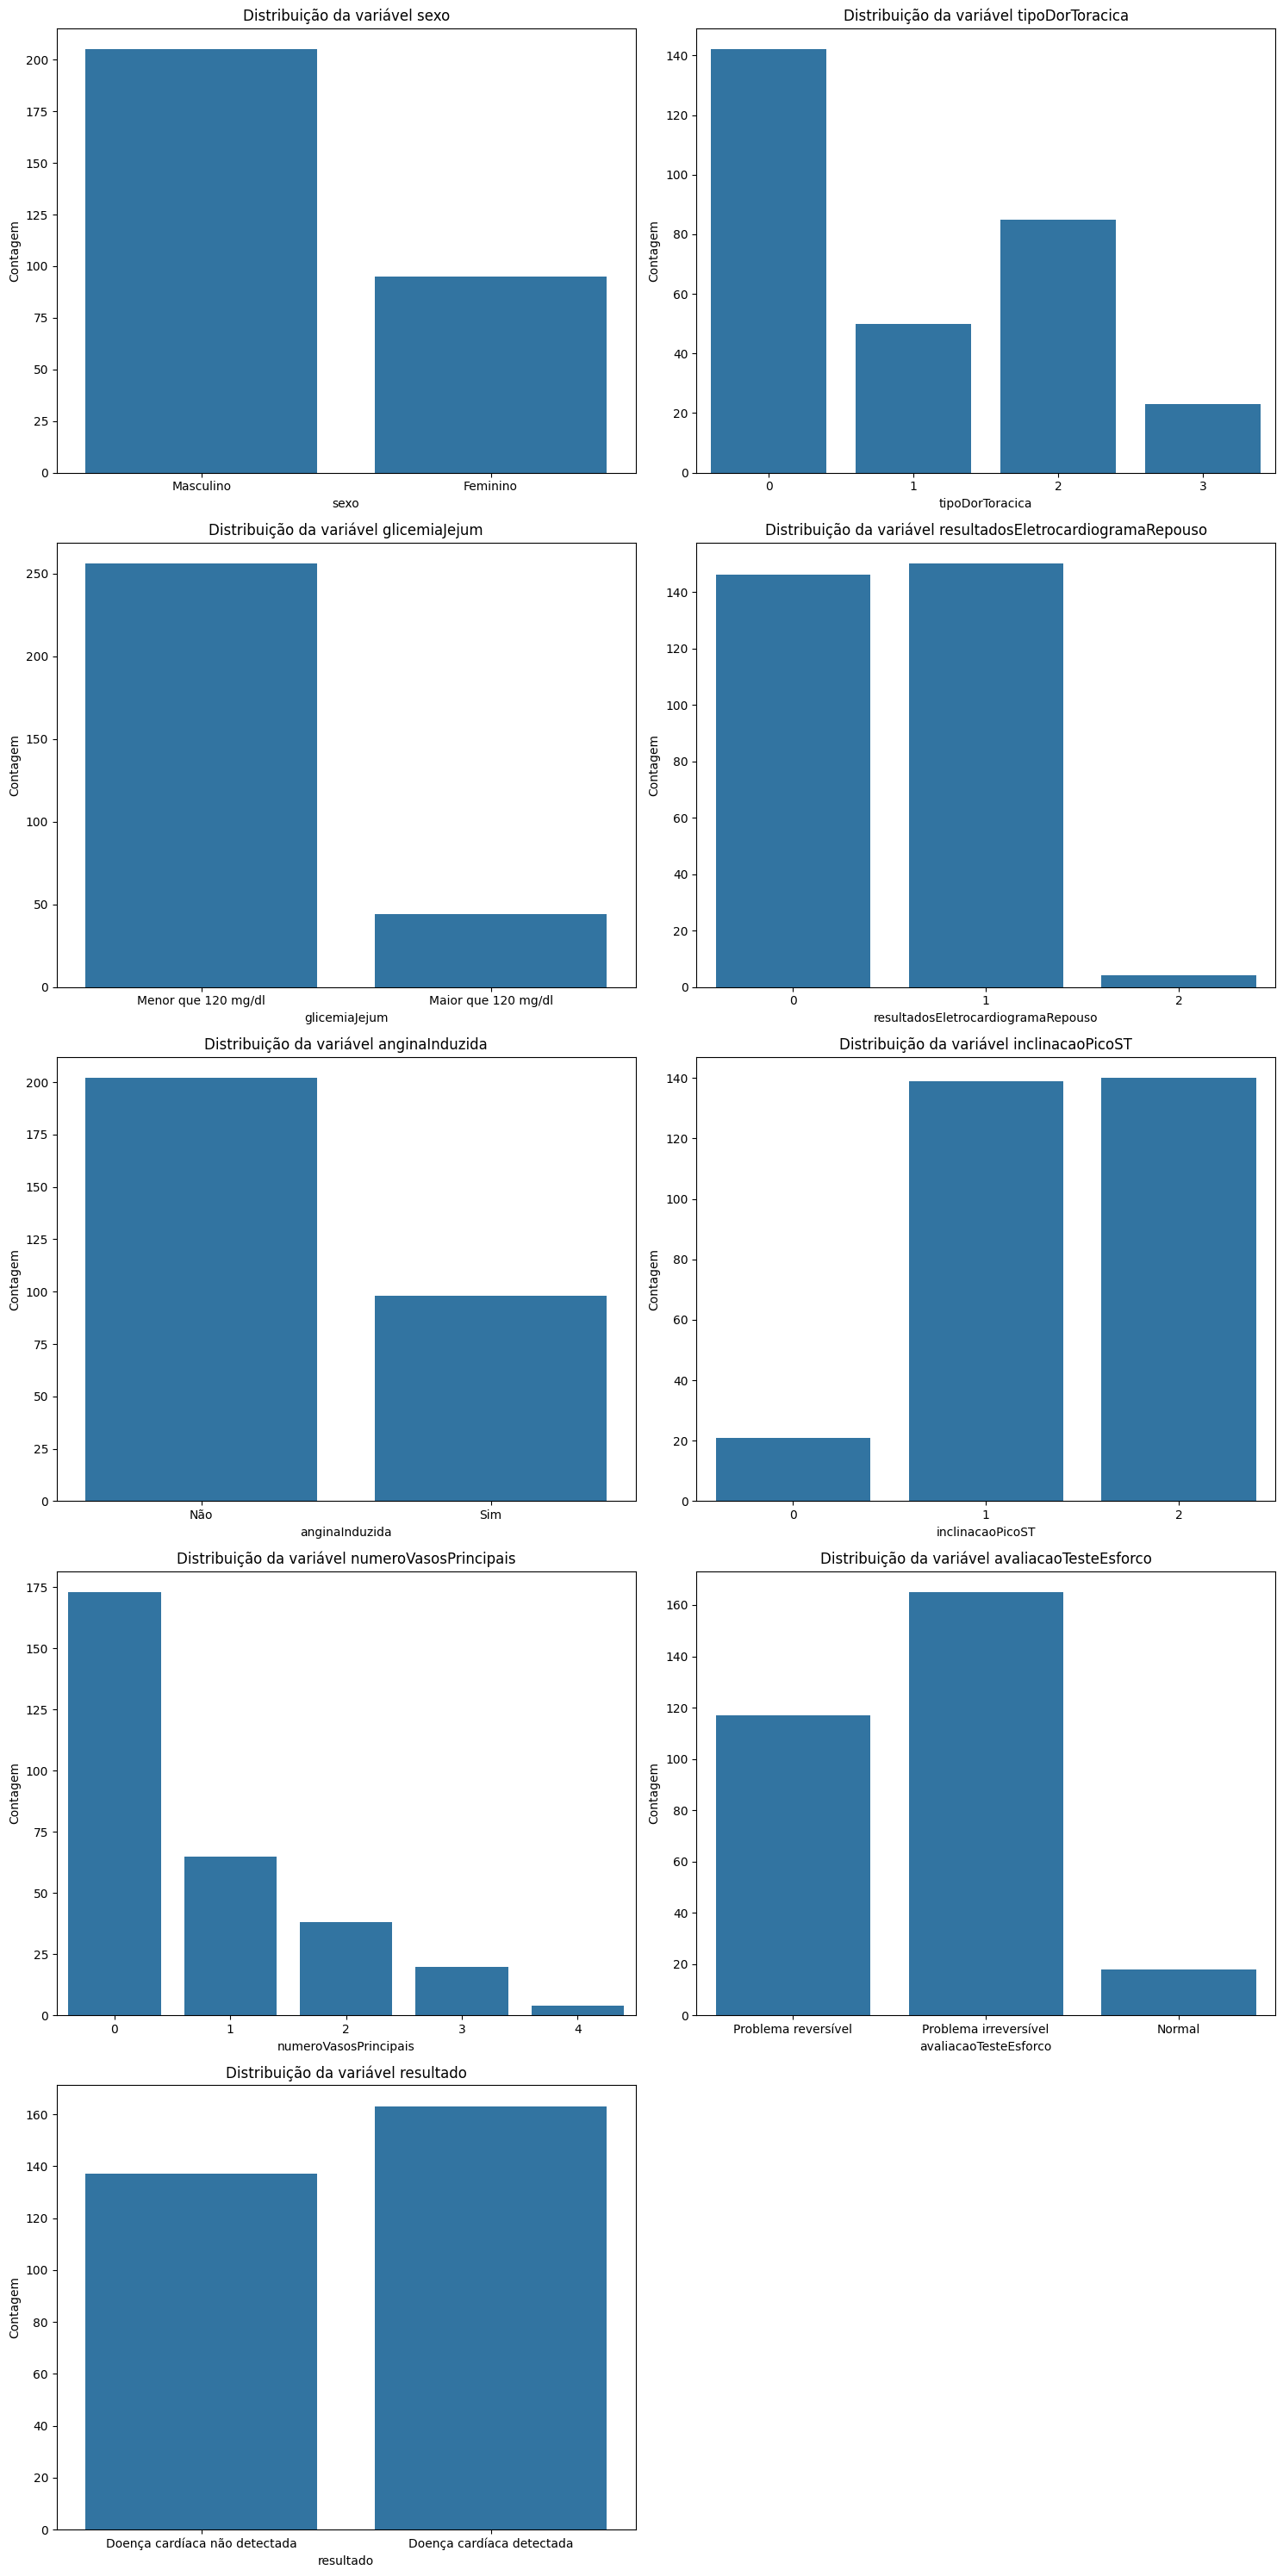

In [18]:
plt.figure(figsize=(15, 30))
num_cols = len(colunas_discretas)

for i, col in enumerate(colunas_discretas):
    plt.subplot((num_cols // 2) + 1, 2, i + 1)
    sns.countplot(x=col, data=df)
    plt.title(f'Distribuição da variável {col}')
    plt.ylabel('Contagem')
    plt.tight_layout()

plt.show()

Com os gráficos de barra acima, é possível perceber que algumas variáveis categóricas possuem desabalanceamentos. Durante a realização da preparação dos dados para o treinamento do modelo, é importante tomar uma decisão acerca desse problema

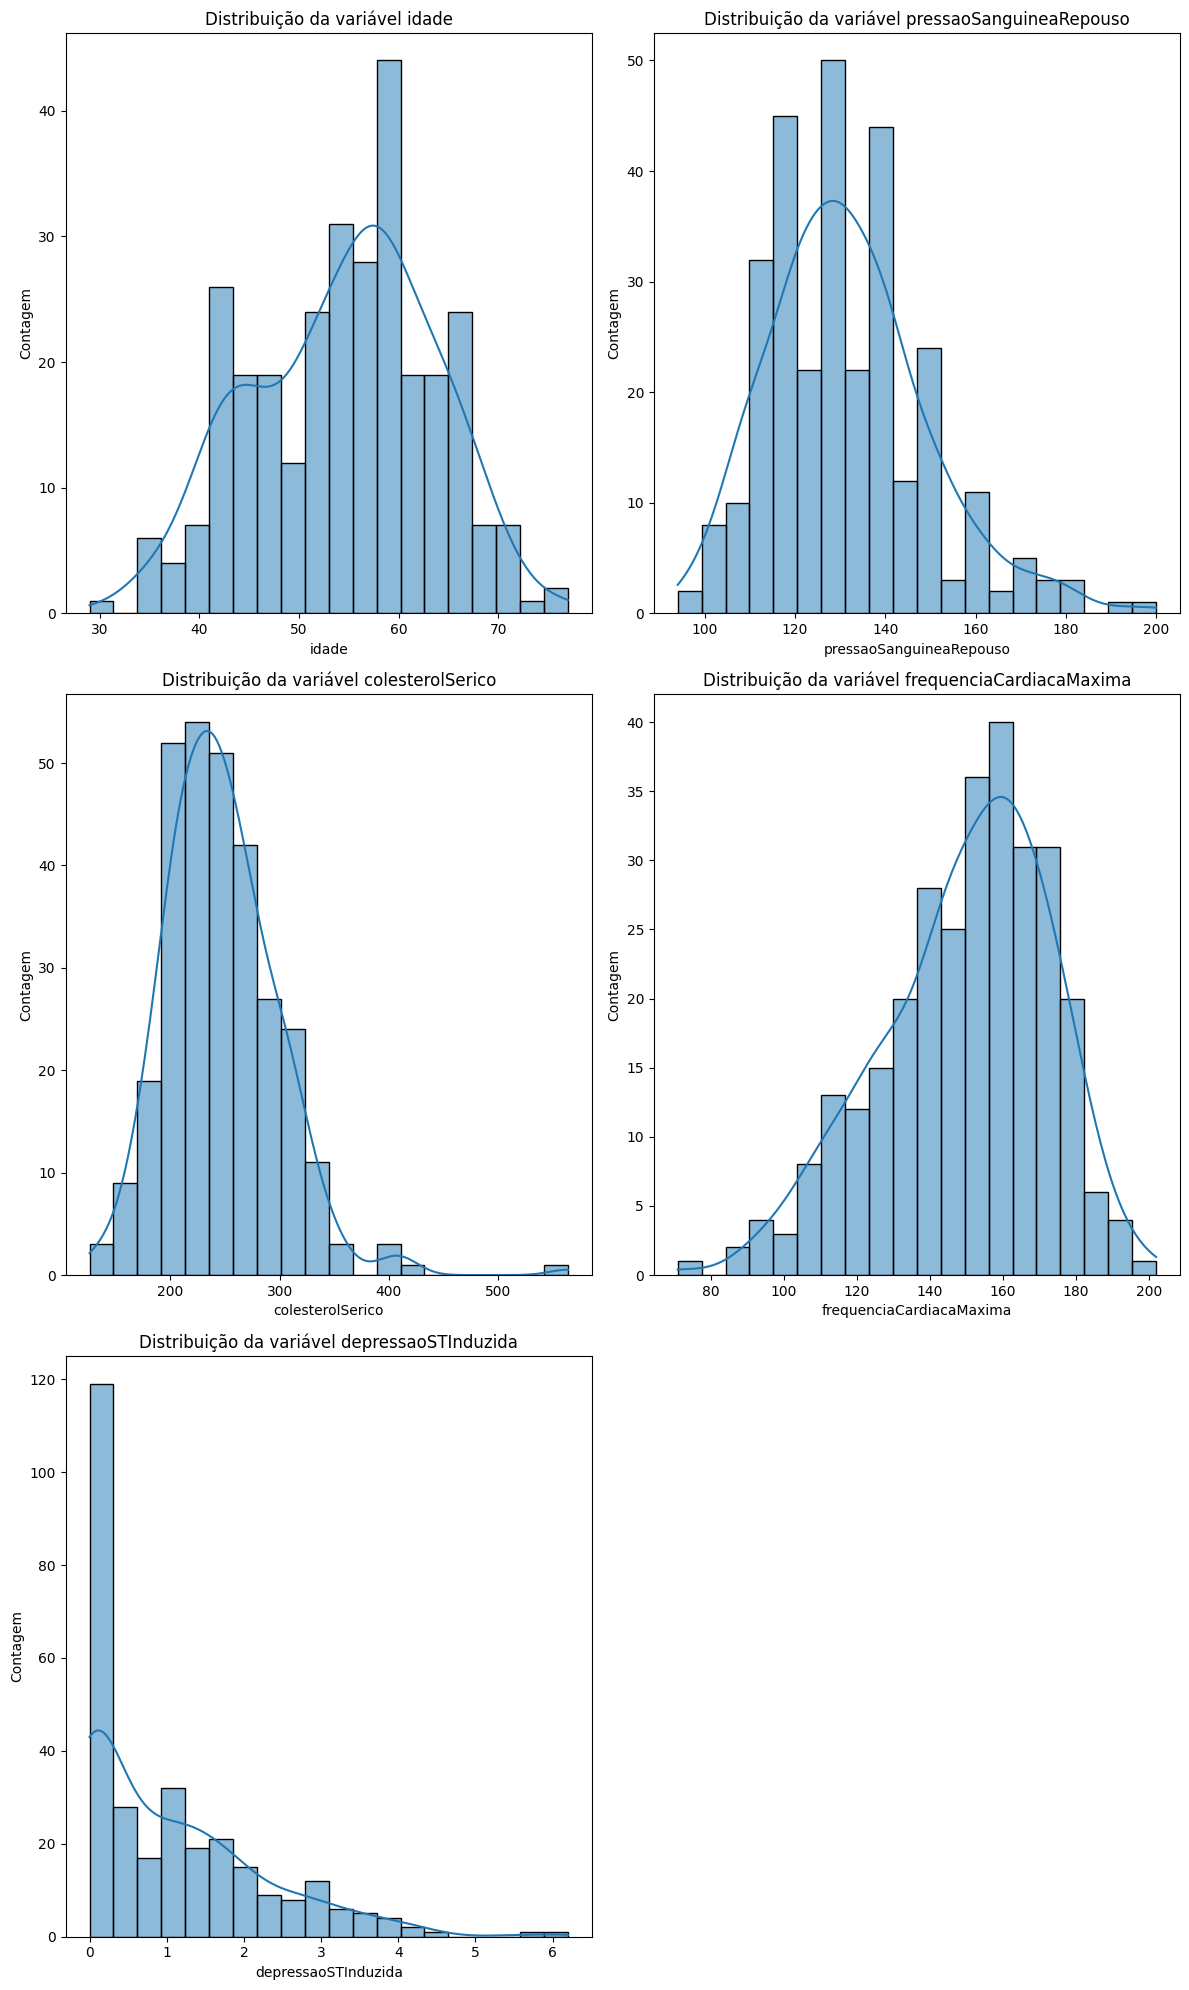

In [19]:
plt.figure(figsize=(12, 20))
num_cols = len(colunas_continuas)

for i, col in enumerate(colunas_continuas):
    plt.subplot((num_cols // 2) + 1, 2, i + 1)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribuição da variável {col}')
    plt.ylabel("Contagem")
    plt.tight_layout()

plt.show()

Dentre as variáveis contínuas da base de dados, algumas têm distribuições que se aproximam da normal enquanto outras possuem distribuições assimétricas. É importante avaliar se essa assimetria não irá prejudicar o treinamento do modelo escolhido

In [20]:
def detectar_outliers_iqr(coluna):
    dados = df[coluna]

    q1 = np.percentile(dados, 25)
    q3 = np.percentile(dados, 75)
    iqr = q3 - q1

    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    outliers = df[(dados < limite_inferior) | (dados > limite_superior)]
    return outliers

In [21]:
for coluna in colunas_continuas:
    outliers = detectar_outliers_iqr(coluna)

    print(f'Análise de outliers - coluna {coluna}')
    print(f'Quantidade de outliers: {outliers.shape[0]}')
    print(f'Porcentagem em relação à base: {round(outliers.shape[0] / df.shape[0] * 100, 2)}')
    print("--------------------")

Análise de outliers - coluna idade
Quantidade de outliers: 0
Porcentagem em relação à base: 0.0
--------------------
Análise de outliers - coluna pressaoSanguineaRepouso
Quantidade de outliers: 9
Porcentagem em relação à base: 3.0
--------------------
Análise de outliers - coluna colesterolSerico
Quantidade de outliers: 5
Porcentagem em relação à base: 1.67
--------------------
Análise de outliers - coluna frequenciaCardiacaMaxima
Quantidade de outliers: 1
Porcentagem em relação à base: 0.33
--------------------
Análise de outliers - coluna depressaoSTInduzida
Quantidade de outliers: 5
Porcentagem em relação à base: 1.67
--------------------


Após a realização da análise de outliers na base utilizando o método do intervalo interquartílico (IQR), um total de 20 registros foram marcados como outliers, o que representa aproximadamente 6,7% dos registros da base. Abaixo, é feita a plotagem de gráficos boxplot para a análise visual dos outliers

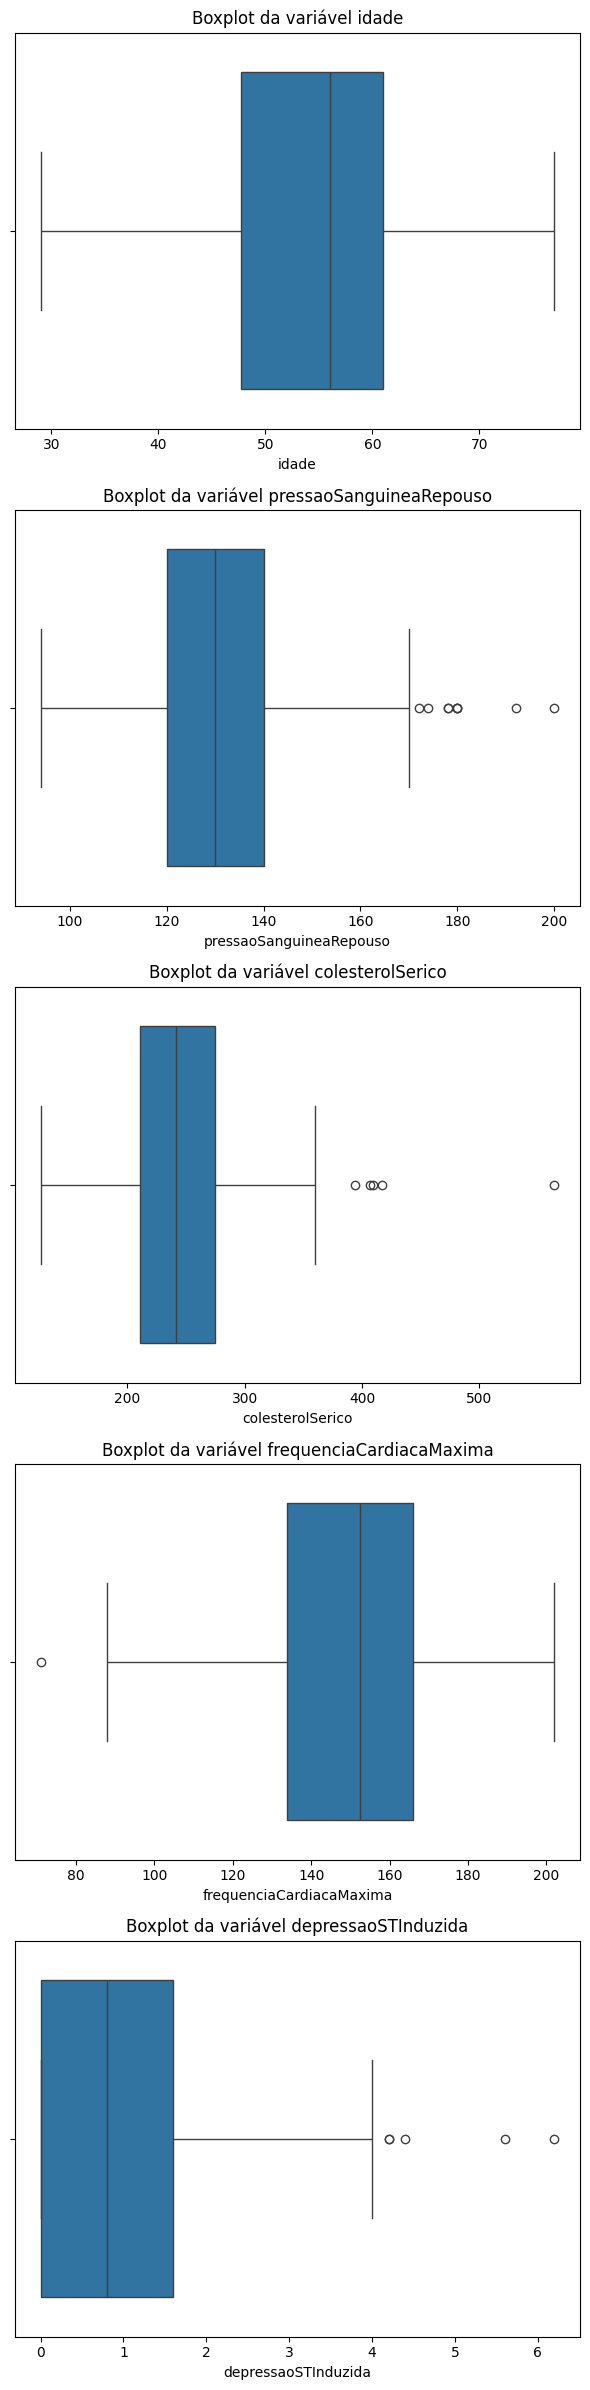

In [22]:
plt.figure(figsize=(6, 24))

for i, coluna in enumerate(colunas_continuas):
    plt.subplot(len(colunas_continuas), 1, i + 1)
    sns.boxplot(x=df[coluna])
    plt.title(f'Boxplot da variável {coluna}')
    plt.xlabel(coluna)

plt.tight_layout()
plt.show()

Diante da porcentagem do número total de outliers, será realizada a remoção dos valores outliers detectados

In [23]:
outliers = pd.DataFrame()

for coluna in colunas_continuas:
    dados = df[coluna]

    q1 = np.percentile(dados, 25)
    q3 = np.percentile(dados, 75)
    iqr = q3 - q1

    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    outliers_detectados = df[(dados < limite_inferior) | (dados > limite_superior)]

    if not outliers_detectados.empty:
        outliers = pd.concat([outliers, outliers_detectados])

In [24]:
outliers.shape[0]

20

In [25]:
df = df.merge(outliers, how='left', indicator=True)
df = df[df['_merge'] == 'left_only'].drop(columns=['_merge'])

In [26]:
for coluna in colunas_continuas:
    outliers = detectar_outliers_iqr(coluna)

    print(f'Análise de outliers - coluna {coluna}')
    print(f'Quantidade de outliers: {outliers.shape[0]}')
    print(f'Porcentagem em relação à base: {round(outliers.shape[0] / df.shape[0] * 100, 2)}')
    print("--------------------")

Análise de outliers - coluna idade
Quantidade de outliers: 0
Porcentagem em relação à base: 0.0
--------------------
Análise de outliers - coluna pressaoSanguineaRepouso
Quantidade de outliers: 0
Porcentagem em relação à base: 0.0
--------------------
Análise de outliers - coluna colesterolSerico
Quantidade de outliers: 0
Porcentagem em relação à base: 0.0
--------------------
Análise de outliers - coluna frequenciaCardiacaMaxima
Quantidade de outliers: 0
Porcentagem em relação à base: 0.0
--------------------
Análise de outliers - coluna depressaoSTInduzida
Quantidade de outliers: 0
Porcentagem em relação à base: 0.0
--------------------


Após a remoção dos outliers detectados anteriormente, a nova busca não detectou nenhum outro valor anormal

In [27]:
df = df.reset_index(drop=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 14 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   idade                               281 non-null    int64  
 1   sexo                                281 non-null    object 
 2   tipoDorToracica                     281 non-null    int64  
 3   pressaoSanguineaRepouso             281 non-null    int64  
 4   colesterolSerico                    281 non-null    int64  
 5   glicemiaJejum                       281 non-null    object 
 6   resultadosEletrocardiogramaRepouso  281 non-null    int64  
 7   frequenciaCardiacaMaxima            281 non-null    int64  
 8   anginaInduzida                      281 non-null    object 
 9   depressaoSTInduzida                 281 non-null    float64
 10  inclinacaoPicoST                    281 non-null    int64  
 11  numeroVasosPrincipais               281 non-n

Para finalizar a limpeza dos dados, os índices do dataset são resetados e algumas informações básicas da base são conferidas

### Preparação dos dados

In [41]:
X = df.drop(columns=['resultado'])
y = df['resultado']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

É realizada a divisão da base em dados de treinamento e de dados que serão usados para o teste do modelo

In [43]:
colunas_categoricas = X.select_dtypes(include=['object', 'category']).columns
colunas_numericas = X.select_dtypes(include=['int64', 'float64']).columns

In [44]:
transformador_numerico = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [45]:
transformador_categorico = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [46]:
preprocessador = ColumnTransformer(transformers=[
    ('num', transformador_numerico, colunas_numericas),
    ('cat', transformador_categorico, colunas_categoricas)
])

São criados dois transformadores - um para a padronização dos dados numéricos e outro para a codificação das variáveis categóricas. O OneHotEncoder foi escolhido porque as coluna categóricas da base de dados não possuem um número alto de classes. Ao final, os dois transformadores foram unidos em um preprocessador

In [47]:
pipeline = Pipeline(steps=[
    ('preprocessamento', preprocessador)
])

In [48]:
X_train_processado = pipeline.fit_transform(X_train)
X_test_processado = pipeline.transform(X_test)

Os dados de treino e de teste são processados para ficarem prontos para o treinamento. O conjunto de treino é utilizado para configurar os parâmetros de normalização e codificação e o conjunto de testes é apenas ajustado. Isso garante que os dados de teste não sejam utilizados de maneira prematura pelo modelo

In [49]:
smote = SMOTE(random_state=42)
X_train_balanceado, y_train_balanceado = smote.fit_resample(X_train_processado, y_train)

Os dados de treinamento passam por um oversample com o algoritmo SMOTE (Synthetic Minority Over-sampling Technique) para reduzir o balanceamento entre as classes

In [50]:
X_train_final = pd.DataFrame(X_train_balanceado, columns=pipeline.get_feature_names_out())
X_test_final = pd.DataFrame(X_test_processado, columns=pipeline.get_feature_names_out())
y_train_final = y_train_balanceado.reset_index(drop=True)
y_test_final = y_test.reset_index(drop=True)

In [51]:
X_train_final.head()

,num__idade,num__tipoDorToracica,num__pressaoSanguineaRepouso,num__colesterolSerico,num__resultadosEletrocardiogramaRepouso,num__frequenciaCardiacaMaxima,num__depressaoSTInduzida,num__inclinacaoPicoST,num__numeroVasosPrincipais,cat__sexo_Feminino,cat__sexo_Masculino,cat__glicemiaJejum_Maior que 120 mg/dl,cat__glicemiaJejum_Menor que 120 mg/dl,cat__anginaInduzida_Não,cat__anginaInduzida_Sim,cat__avaliacaoTesteEsforco_Normal,cat__avaliacaoTesteEsforco_Problema irreversível,cat__avaliacaoTesteEsforco_Problema reversível
0,2.154972,-0.004454,-0.646443,0.584865,-1.000308,-1.271152,-0.727451,0.942864,0.273843,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,-0.249307,-0.004454,-0.105880,-0.869788,0.965209,1.469642,-0.918258,0.942864,-0.715526,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.297120,-1.002240,0.164401,-0.824330,0.965209,0.773567,-0.918258,0.942864,-0.715526,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,-0.030737,-1.002240,-0.376161,0.516678,-1.000308,-1.793207,1.180617,-0.720140,0.273843,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,-0.030737,0.993331,-1.457286,0.539407,-1.000308,0.730062,-0.918258,0.942864,-0.715526,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [52]:
y_train_final.head()

0        Doença cardíaca detectada
1        Doença cardíaca detectada
2        Doença cardíaca detectada
3    Doença cardíaca não detectada
4        Doença cardíaca detectada
Name: resultado, dtype: object

Para finalizar a preparação dos dados, os 4 conjuntos de dados que serão usados pelo modelo são ajustados para o formato de dataframe caso seja preciso salvar os datasets

### Treinamento e testagem do modelo

In [53]:
modelo = DecisionTreeClassifier(random_state=42)

In [54]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

O modelo usado para a previsão será um modelo de árvores de decisão, que é adequado para uma base de dados pequena, como a que está sendo utilizada. Para encontrar os melhores parâmetros e evitar overfitting, será realizada uma busca de parâmetros com GridSearch

In [55]:
cross_validation = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

In [56]:
grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cross_validation,
    n_jobs=-1,
    verbose=1
)

In [57]:
grid_search.fit(X_train_balanceado, y_train_balanceado)

Fitting 15 folds for each of 36 candidates, totalling 540 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy', verbose=1)

O grid search é configurado e executado utilizando a acurácia como parâmetro de decisão para escolher o melhor modelo

In [58]:
melhor_modelo = grid_search.best_estimator_
print("Parâmetros selecionados: ", grid_search.best_params_)
print("Melhor acurácia média na validação cruzada", grid_search.best_score_)

Parâmetros selecionados:  {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Melhor acurácia média na validação cruzada 0.8306666666666668


Acima, vemos a melhor configuração de parâmetros encontrada pelo grid search e a melhor acurácia média na validação cruzada

In [59]:
y_pred = melhor_modelo.predict(X_test_processado)

In [60]:
print("Acurácia no conjunto de teste: ", accuracy_score(y_test, y_pred))
print("\nRelatório de classificação: ", classification_report(y_test, y_pred))

Acurácia no conjunto de teste:  0.7894736842105263

Relatório de classificação:                                 precision    recall  f1-score   support

    Doença cardíaca detectada       0.81      0.81      0.81        32
Doença cardíaca não detectada       0.76      0.76      0.76        25

                     accuracy                           0.79        57
                    macro avg       0.79      0.79      0.79        57
                 weighted avg       0.79      0.79      0.79        57



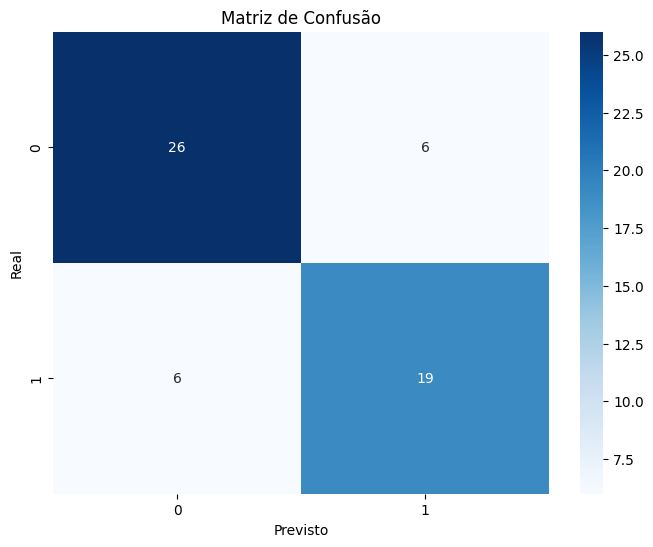

In [61]:
matriz_confusao = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

Com a testagem do modelo usando os dados de treinamento, a acurácia do modelo foi de aproximadamente 79%. Os resultados dos testes podem ser melhor verificados por meio do relatório de classificação e da matriz de confusão acima

### Exportação do modelo

In [62]:
pipeline_pmml = PMMLPipeline(steps=[
    ('preprocessamento', preprocessador),
    ('modelo', grid_search.best_estimator_)
])

pipeline_pmml.fit(X_train, y_train)

PMMLPipeline(steps=[('preprocessamento', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['idade', 'tipoDorToracica', 'pressaoSanguineaRepouso',
       'colesterolSerico', 'resultadosEletrocardiogramaRepouso',
       'frequenciaCardiacaMaxima', 'depressaoSTInduzida', 'inclinacaoPicoST',
       'numeroVasosPrincipais'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 Index(['sexo', 'glicemiaJejum', 'anginaInduzida', 'avaliacaoTesteEsforco'], dtype='object'))])),
       ('modelo', DecisionTreeClassifier(max_depth=3, min_samples_leaf=4, random_state=42))])

In [64]:
sklearn2pmml(pipeline_pmml, "modelo_heart_disease.pmml", with_repr=True)

O modelo foi exportado em um arquivo PMML que será utilizado por uma API para a realização de previsões